## Object-Oriented Approach to Digit Recognition

After achieving an accuracy of 89% on the test set, we can confidently state that our model performs well enough for practical use. However, testing its performance in real-world scenarios is crucial to ensure its robustness and reliability.

To achieve this, we will encapsulate the digit recognition process within a Python class. This object-oriented approach allows us to organize the functionality into a reusable and modular structure. Additionally, we will conduct various experiments to evaluate how the model behaves under different conditions and test cases.

### Goals of This Implementation

- **Evaluate Model Performance**: Test the model's accuracy and reliability in diverse scenarios.
- **Experiment with Variations**: Assess how the model handles different inputs, including noisy or distorted digits.
- **Identify Areas for Improvement**: Analyze results to uncover potential enhancements for the model.

By structuring our implementation as a class, we ensure that the digit recognition pipeline is clean, maintainable, and extensible for future improvements.

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
from rich.console import Console
from time import time
import logging

In [2]:
console = Console()

## Digit Recognition Class

In [9]:
class DigitClassification:
    '''
    Class to classify digits using GMM with Kmeans or EM algorithm
    '''
    def __init__(self, n_components, method='kmeans', covariance_type='full', digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
        '''
        Initialize the class with the training data and the number of clusters
        :param n_components: number of clusters
        :param method: method to use for clustering
        :param covariance_type: covariance type for GMM
        :param digits: digits to classify
        '''
        self.method = method
        self.covariance_type = covariance_type
        self.models = []
        self.n_components = [n_components] * 10
        self.digits = digits
        
    def fit(self, X_train, y_train):
        '''
        Fit the model to the training data
        :param X_train: training data
        :param y_train: training labels
        '''
        console.log(f"Training GMM - {self.method} method | {self.covariance_type} covariance type | {self.n_components[0]} components | {len(X_train)} samples")
        for digit in tqdm(self.digits, desc='Fitting digits in GMM', position=0, colour='green',unit_scale=True, dynamic_ncols=True, smoothing=0.1):
            # Filter the data for the digit
            X_digit = X_train[y_train == digit]
            if self.method == 'kmeans':
                # Fit the model
                self._gmm_kmeans_fitting(X_digit, digit)
            elif self.method == 'em':
                model = make_pipeline(StandardScaler(), GaussianMixture(n_components=self.n_components[digit], covariance_type=self.covariance_type))
                model.fit(X_digit)
            else:
                raise ValueError("Invalid method")
    
    def _gmm_em_fitting(self, X, digit):
        """
        Fit the GMM model to the data using EM.
        :param X: Data to fit.
        :param digit: The digit being processed.
        """
        mfccs = np.vstack([np.array(utt) for utt in X])  # Stack the data
        gmm = GaussianMixture(n_components=self.n_components[digit], covariance_type=self.covariance_type)
        gmm.fit(mfccs)
        self.models.append(gmm)
    
    def _gmm_kmeans_fitting(self, X, digit):
        """
        Fit the GMM model to the data using KMeans.
        :param X: Data to fit.
        :param digit: The digit being processed.
        """
        model = KMeans(n_clusters=self.n_components[digit])  # KMeans model
        mfccs = np.vstack([np.array(utt) for utt in X])  # Stack the data
        
        # Fit KMeans
        model.fit(mfccs)
        
        cluster_labels = model.labels_  # Get the cluster labels
        
        cw = []  # Cluster weights
        mu = []  # Cluster means
        sigma = []  # Cluster covariances
        
        if self.covariance_type == 'tied':
            mfccs_centered = mfccs - np.mean(mfccs, axis=0)
            tied_cov = np.cov(mfccs_centered, rowvar=False)
        
        for cluster in range(self.n_components[digit]):
            cluster_mfccs = mfccs[cluster_labels == cluster]  # Filter data for the cluster
            
            if len(cluster_mfccs) == 0:
                raise ValueError(f"No data points found in cluster {cluster}.")
            
            cw.append(len(cluster_mfccs) / len(mfccs))  # Calculate cluster weight
            mu.append(np.mean(cluster_mfccs, axis=0))  # Calculate cluster mean
            
            if self.covariance_type == 'full':
                sigma.append(np.cov(cluster_mfccs, rowvar=False))
            elif self.covariance_type == 'tied':
                sigma.append(tied_cov)
            elif self.covariance_type == 'diag':
                sigma.append(np.diag(np.var(cluster_mfccs, axis=0)))
            elif self.covariance_type == 'spherical':
                sigma.append(np.var(cluster_mfccs))
            else:
                raise ValueError("Invalid covariance type.")
        
        cw = np.array(cw)
        mu = np.array(mu)
        
        # Convert sigma to a NumPy array with the correct shape
        if self.covariance_type in ['full', 'diag']:
            sigma = np.array(sigma)
        
        gmm = GaussianMixture(n_components=self.n_components[digit], covariance_type=self.covariance_type)
        gmm.weights_ = cw
        gmm.means_ = mu
        
        if self.covariance_type != 'tied':
            gmm.covariances_ = sigma
            gmm.precisions_cholesky_ = _compute_precision_cholesky(gmm.covariances_, self.covariance_type)
        else:
            gmm.covariances_ = tied_cov
            gmm.precisions_cholesky_ = _compute_precision_cholesky(tied_cov, 'tied')
        
        self.models.append(gmm)
        
    def predict(self, X_test):
        """
        Predict the digit for each test sample using trained GMM models.
        
        :param X_test: List or array of test samples (e.g., MFCC features for each utterance).
        :return: Array of predicted digits for each test sample.
        """
        # Initialize an array to store predictions
        predictions = np.zeros(len(X_test), dtype=int)  # Use dtype=int since predictions are class labels
        
        # Iterate over test samples with a progress bar
        for ix, utterance in tqdm(
            enumerate(X_test),
            desc="Predicting digits with GMM",
            position=0,
            colour="green",
            unit="utterance",
            dynamic_ncols=True,
            smoothing=0.1,
        ):
            # Convert the utterance to a NumPy array (if not already)
            mfccs = np.array(utterance)

            # Calculate likelihood for each digit model
            digit_likelihoods = [np.sum(model.score_samples(mfccs)) for model in self.models]

            # Find the digit with the highest likelihood
            predicted_digit = np.argmax(digit_likelihoods)

            # Store the prediction
            predictions[ix] = predicted_digit

        return predictions
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the GMM model on test data.
        
        :param X_test: List or array of test samples (e.g., MFCC features for each utterance).
        :param y_test: Array of true labels for the test samples.
        :return: Accuracy of the model on the test data.
        """
        # Predict the test data
        predictions = self.predict(X_test)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, predictions)
        cm = confusion_matrix(y_test, predictions)
        
        return accuracy, cm
    
    def computing_cost(self, X_train, y_train, X_test, y_test):
        """
        Compute the cost of the model on the training data calculating the time taken to fit and predict the data.
        
        :param X_train: List or array of training samples (e.g., MFCC features for each utterance).
        :param y_train: Array of true labels for the training samples.
        :param X_test: List or array of test samples (e.g., MFCC features for each utterance).
        :param y_test: Array of true labels for the test samples.
        :return: Cost of the model on the training data.
        """
        # start timer for training
        start = time.time()
        self.fit(X_train, y_train)
        end = time.time()
        
        # Calculate the time taken to fit the model
        training_time = end - start
        
        # start timer for prediction
        start = time.time()
        self.predict(X_test)
        end = time.time()
        
        # Calculate the time taken to predict the model
        prediction_time = end - start
        
        return training_time, prediction_time
            

### Example Usage

In [4]:
# example usage
df_train = pd.read_csv('../data/train_grouped.csv')
df_test = pd.read_csv('../data/test_grouped.csv')

X_train = df_train['coefficients'].apply(lambda x: np.array(eval(x)))
y_train = df_train['digit'].values

X_test = df_test['coefficients'].apply(lambda x: np.array(eval(x)))
y_test = df_test['digit'].values

In [5]:
dc = DigitClassification(5, method='kmeans')
dc.fit(X_train, y_train)

[13:34:52] Training GMM - kmeans method | full covariance type | 5 components | 6600 samples        ]8;id=113924;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/526531279.py\526531279.py]8;;\:]8;id=175184;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/526531279.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

In [6]:
dc.predict(X_test)

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

array([0, 0, 0, ..., 7, 9, 6])

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

Accuracy: 0.8686363636363637


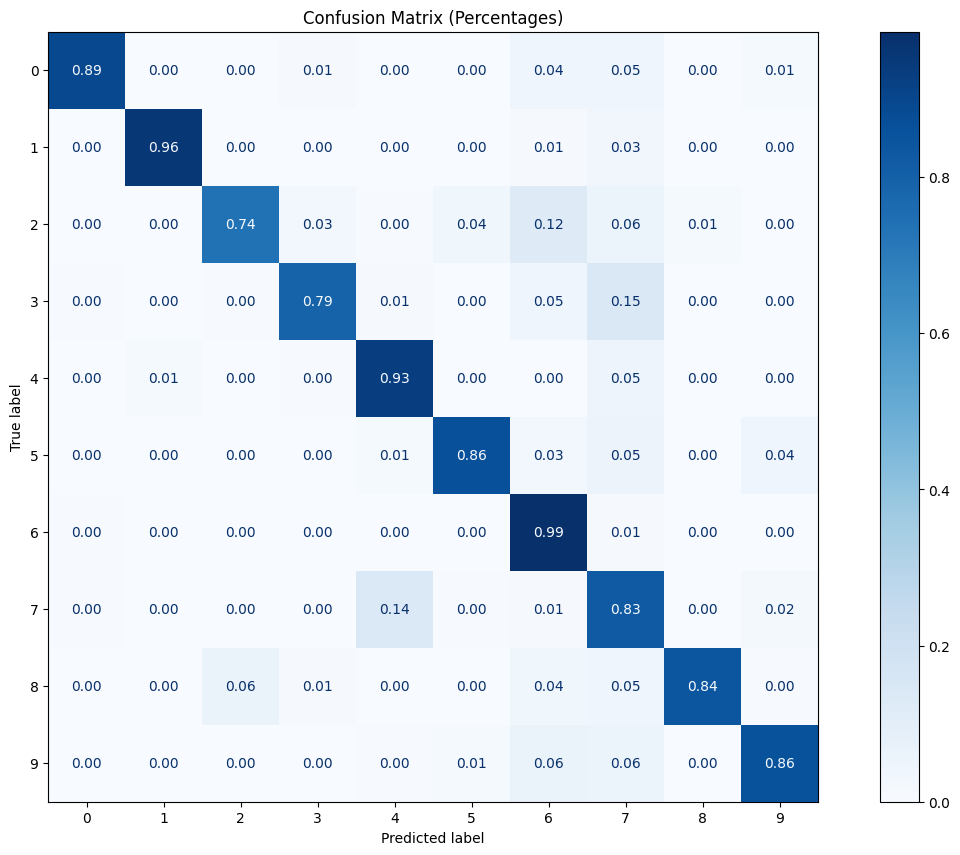

In [7]:
acc, cm = dc.evaluate(X_test, y_test)
print(f"Accuracy: {acc}")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (percentages)

# ------------------- Display Confusion Matrix -------------------
fig, ax = plt.subplots(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(10)])
disp.plot(values_format=".2f", ax=ax, cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.show()

## Experiment comparing EM and Kmeans initialization of GMM for digit recognition

In [24]:
covariance_types = ['full', 'tied', 'diag', 'spherical']
methods = ['kmeans', 'em']
iterations = [1, 5, 10, 20, 50, 100]
n_components = 7

In [25]:
# Initialize logging
logging.basicConfig(filename="training_errors.log", level=logging.ERROR)

In [26]:
# Initialize a dictionary to store results
results = {
    "Covariance": [],
    "Method": [],
    "Iteration": [],
    "Accuracy": []
}

Covariance Type:   0%|          | 0/4 [00:00<?, ?it/s]

Method:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

[13:55:30] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=761037;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=496195;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

[13:55:32] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=934349;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=231120;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

[13:55:35] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=232788;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=870135;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

[13:55:38] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=95218;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=829454;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

[13:55:41] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=714812;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=160479;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

[13:55:43] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=37572;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=76231;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

Predicting digits with GMM: 0utterance [00:00, ?utterance/s]

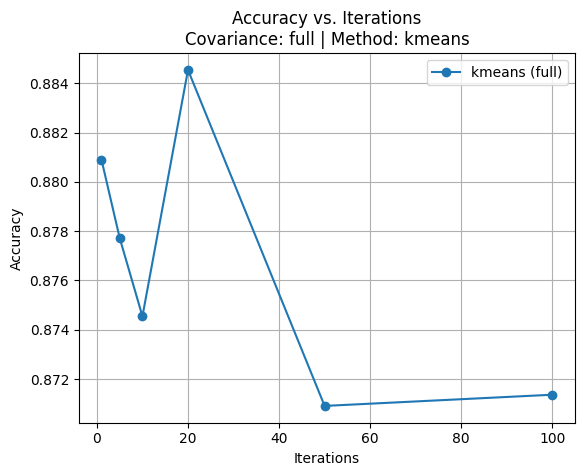

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

[13:55:46] Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=994317;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=270513;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=161761;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=411047;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=767836;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=842079;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=890765;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=905097;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=482796;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=170703;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=34269;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=395142;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

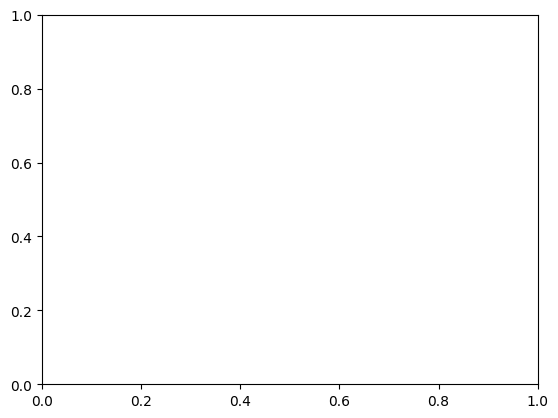

In [27]:

# Loop through configurations
for cov in tqdm(covariance_types, desc="Covariance Type"):
    for method in tqdm(methods, desc="Method", leave=False):
        accuracies = []
        for n in tqdm(iterations, desc="Iterations", leave=False):
            try:
                # Initialize and train model
                dc = DigitClassification(n_components=n_components, method=method, covariance_type=cov)
                dc.fit(X_train, y_train)

                # Evaluate model
                acc, cm = dc.evaluate(X_test, y_test)
                accuracies.append(acc)

                # Save results
                results["Covariance"].append(cov)
                results["Method"].append(method)
                results["Iteration"].append(n)
                results["Accuracy"].append(acc)

            except ValueError as e:
                logging.error(f"Error for Covariance={cov}, Method={method}, Iteration={n}: {e}")
                continue

        # Plot results for the current configuration
        plt.plot(iterations, accuracies, marker="o", label=f"{method} ({cov})")
        plt.title(f"Accuracy vs. Iterations\nCovariance: {cov} | Method: {method}")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.show()

Covariance: full | Method: kmeans:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=1]

[13:52:31] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=964431;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=953581;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 32.3it/s]
Predicting digits with GMM: 2200utterance [00:01, 1180.45utterance/s]
Covariance: full | Method: kmeans:  17%|█▋        | 1/6 [00:02<00:10,  2.18s/it, Iteration=5]

[13:52:33] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=306163;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=326100;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 28.1it/s]
Predicting digits with GMM: 2200utterance [00:01, 1181.39utterance/s]
Covariance: full | Method: kmeans:  33%|███▎      | 2/6 [00:04<00:08,  2.21s/it, Iteration=10]

[13:52:35] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=954343;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=272385;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 39.9it/s]
Predicting digits with GMM: 2200utterance [00:01, 1153.33utterance/s]
Covariance: full | Method: kmeans:  50%|█████     | 3/6 [00:06<00:06,  2.19s/it, Iteration=20]

[13:52:37] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=69674;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=394917;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 34.9it/s]
Predicting digits with GMM: 2200utterance [00:01, 1140.22utterance/s]
Covariance: full | Method: kmeans:  67%|██████▋   | 4/6 [00:08<00:04,  2.23s/it, Iteration=50]

[13:52:40] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=377857;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=794048;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 36.1it/s]
Predicting digits with GMM: 2200utterance [00:01, 1114.74utterance/s]
Covariance: full | Method: kmeans:  83%|████████▎ | 5/6 [00:11<00:02,  2.24s/it, Iteration=100]

[13:52:42] Training GMM - kmeans method | full covariance type | 7 components | 6600 samples       ]8;id=608769;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=670848;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM: 100%|██████████| 10.0/10.0 [00:00<00:00, 30.7it/s]
Predicting digits with GMM: 2200utterance [00:01, 1144.23utterance/s]
Covariance: full | Method: kmeans: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it, Iteration=100]


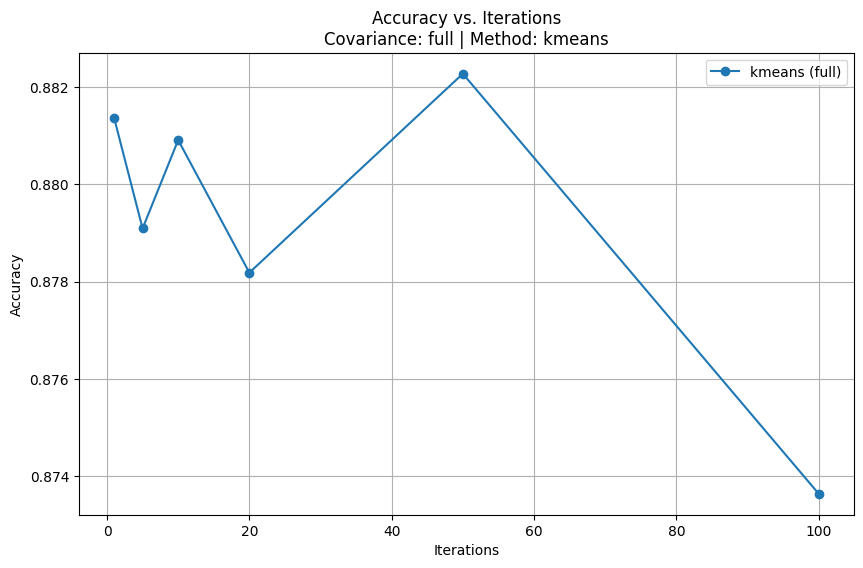

Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=1]

[13:52:44] Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=289660;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=117692;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=5]

Error during training: setting an array element with a sequence.


           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=525371;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=93097;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=10]

Error during training: setting an array element with a sequence.


           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=603322;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=325335;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=20]

Error during training: setting an array element with a sequence.


           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=407676;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=578948;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=50]

Error during training: setting an array element with a sequence.


           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=138264;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=459404;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em:   0%|          | 0/6 [00:00<?, ?it/s, Iteration=100]

Error during training: setting an array element with a sequence.


           Training GMM - em method | full covariance type | 7 components | 6600 samples           ]8;id=805692;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py\3336050193.py]8;;\:]8;id=370611;file:///var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_49995/3336050193.py#25\25]8;;\

Fitting digits in GMM:   0%|          | 0.00/10.0 [00:00<?, ?it/s]
Covariance: full | Method: em: 100%|██████████| 6/6 [00:00<00:00, 58.79it/s, Iteration=100]


Error during training: setting an array element with a sequence.


ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

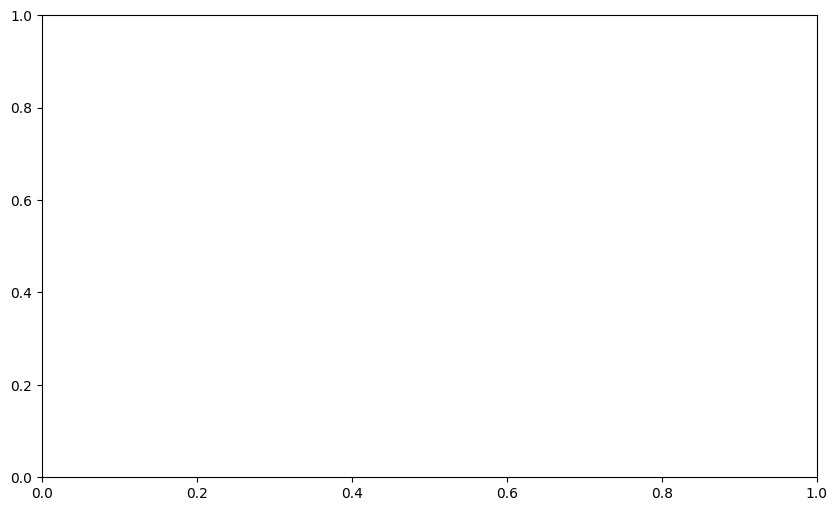

In [ ]:


# Train and evaluate the model
for cov in covariance_types:
    for method in methods:
        accuracies = []

        with tqdm(iterations, desc=f"Covariance: {cov} | Method: {method}") as progress_bar:
            for n in progress_bar:
                progress_bar.set_postfix({"Iteration": n})

                # Initialize model
                dc = DigitClassification(n_components=n_components, method=method, covariance_type=cov)
                
                # Ensure input format is correct before training
                try:
                    dc.fit(X_train, y_train)
                except ValueError as e:
                    print(f"Error during training: {e}")
                    continue

                # Evaluate model
                acc, cm = dc.evaluate(X_test, y_test)
                accuracies.append(acc)

                # Save results
                results["Covariance"].append(cov)
                results["Method"].append(method)
                results["Iteration"].append(n)
                results["Accuracy"].append(acc)

        # Plot accuracies
        plt.figure(figsize=(10, 6))
        plt.plot(iterations, accuracies, marker="o", label=f"{method} ({cov})")
        plt.title(f"Accuracy vs. Iterations\nCovariance: {cov} | Method: {method}")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.show()

## Experiment with different covariances types